## Implementación de Máquina de Soporte Vectorial con scipy optimize




Supongamos un conjunto de datos con $p$ características y $n$ muestras que nos permitirán clasificar cada muestra según 2 clases distintas. Para ello podríamos valernos de un hiperplano (por ej. una recta en $ \mathbb{R}^{2} $, sí las clases son linearmente separables). Un vector $w$, normal al hiperplano nos provería de la siguiente ecuación:

$$ w^T . x + b = 0, w \in \mathbb{R}^{p}, x \in \mathbb{R}^{p}, b \in \mathbb{R} $$

Dado un vector $x_0$ perteneciente al hiperplano, la distancia de un vector $x$ al hiperplano es:

$$ w . (x - x_0) = w^T . x + b $$

Sí las etiquetas de cada clase $y$, tal que $y \in \{-1, 1\}$, la distancia con su signo es:

$$ y (w^T . x + b) $$



Para poder clasificar cada vector $x$ bastaría con ver su signo: siendo $x^+$ un vector de la clase $1$ y $x^-$ un vector de la clase $-1$, entonces:

$$ w^T . x^+ + b \ge 0$$        $$w^T . x^- + b \leq 0$$

Sí consideramos dos hiperplanos paralelos y equidistantes al de nuestra solución, los cuáles llamaremos margenes, podemos requerir que nuestro modelo busque una separación de clases más amplia tal que entre esos margenes no existan vectores, entonces para ese caso se debería satisfacer: 

$$ y(w^T . x + b) \ge 1$$ con $y=1$ para $x^+$, $y=-1$ para $x^- $. $(1)$

Y los vectores $x'$ que cumplen la igualdad $y (w^T . x' + b) -1 = 0$ $(2)$ son los llamados vectores soportes que viven exactamente en alguno de esos margenes, dependiendo el valor de $y$.




![Vectores soporte](https://ichi.pro/assets/images/max/724/1*Rpw8EXp3kI_dObeSlZ4RWw.png)

Sí bien para esta implementación solo se tendrá en cuenta el hiperplano de separación para la clasificación y no los márgenes equidistantes mencionados anteriormente, esta condición también lleva a la maximización del problema en cuestión.


Podemos calcular la distancia $d$ entre estos dos margenes, sabiendo la distancia del margen de la clase $-1$: $d_{-}$ y de la clase $1$: $d_{+}$. 
$$ d_{-} = \frac{x^- . w}{\Vert w \Vert}$$ $$ d_{+} = \frac{x^+ . w}{\Vert w \Vert}$$

$$ d = d_{+} - d{-} =  \frac{x^+ . w - x^- . w}{\Vert w \Vert}$$

Para los vectores soporte solo basta reemplazar en $(2)$  en $d$ con $y = 1$ para los vectores soportes de la clase 1 y $y = -1$ para los vectores de la clase $-1$, obteniendo: 

$$ d =  \frac {1 + b - 1 + b }{\Vert w \Vert} = \frac {2}{\Vert w \Vert}  $$

$d$ es lo que debemos maximizar, o equivalentemente mimizar: 

$$ d =  \frac {1}{2} w^T . w \ \ \ \ (3) $$      

Sujeto a la condición  $(1)$, la cuál podemos reescribir: 

$$ -y(w^T . x + b) +1\le 0 \ \ \ \ (4) $$ 

Tanto $(3)$ como $(4)$ son funciones convexas, por lo que la solución al problema de minimización debe satisfacer las condiciones de **Karush Kun Tucker**, principalmente se debe verificar:

$$ \alpha_i g_i w^* = 0 \ \ \ \ (a) $$

$$ g_i w^* \le 0  \ \ \ \ (b) $$

$$ \alpha_i \ge 0 \ \ \ \ (c) $$

Con $i$ de 1,...,n, $w^*$ la solución al problema y $g_i$ siendo la condición $(4)$.
Se puede ver que $(4)$ será $0$ solo en los vectores soporte, por lo que $\alpha_i$ serán valores no nulos solo para los vectores soporte $x_i'$. Esta condición será de vital importancia para identificarlos en la implementación.

Para resolver este problema de minimización, se pueden utilizar los multiplicadores de Lagrange obteniendo la nueva función $\mathcal{L}$ : 

$$\mathcal{L}(w, b, \alpha) = \frac 12 \Vert w \Vert^2 - \sum_{i=0}^n \alpha_i (y_i(x_i^T w + b) - 1)  \ \ \ \ (5)$$

Para poder minimizar se debe encontrar dónde las derivadas parciales de $\mathcal{L}$ son iguales a 0:

$$\begin{align}
\frac{d\mathcal{L}}{dw} = \sum_{i=0}^n \alpha_i y_i x_i &= w \ \ \ (6) \\
\frac{d\mathcal{L}}{db} = \sum_{i=0}^n \alpha_i y_i &= 0 \ \ \ \ (7)
\end{align}$$

Reemplazando $(6)$ en $(5)$ se obtiene: 

$$\mathcal{L} (\alpha) = \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \alpha_i \alpha_k y_i y_k (x_i^T . x_k) \ \ \ \ (8) $$

Finalmente hemos llegado a la expresión que debemos minimizar. Es importante notar el producto punto $(x_i^T . x_k)$ el cuál puede ser objeto de transformaciones para problemas de clases no linealmente separables.

Las restricciones que utilizaremos en la implementación serán:

$$ \alpha_i \ge 0 \ \ \ \ (c) $$
$$ \sum_{i=0}^n \alpha_i y_i = 0 \ \ \ \ (7) $$


Para resolver el problema se utilizará de la librería **scipy.optimize** la función **minimize** [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

Para ello se creará la clase **SVM**, que tendrá un método **fit** para entrenar el modelo con los datos ingresado y luego una función propia de predicción **predict** para testearlo con nuevos datos. 

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
from sklearn.datasets import load_breast_cancer

In [88]:
class SVM:
    
    def __init__(self):
        self.alpha = None #multiplicadores de lagrange
        self.w = None #vector perpendicular al hiperplano de separación
        self.supportVectors = None 
        self.b = None 
        
        
    def fit(self, X, y):
        self.X = X
        N = len(y)
        # HXy será la Matriz de productos punto de la ecuación a optimizar
        Xy = X * y[:, np.newaxis]
        HXy = Xy @ Xy.T
        
        # Lagrangiana
        def Ld0(H, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(H)) #(8)

        # Derivada parcial de la función Lagrangiana respecto a alfa
        def Ld0_(H, alpha):
            return np.ones_like(alpha) - alpha.dot(H)

        # Restricciones :
        # -  1: sum_i alpha_i*y_i = 0 (7)
        # - 2: alpha_i >= 0 restriccion por condición de KKT (c), nos auxiliamos de 2 matrices para expresar la desigualdad:
        # la identidad A para realizar el producto punto con los alphas y la matriz de 0 d
        A = -np.eye(N)
        d = np.zeros(N)
        restr = ({'type': 'eq',   'fun': lambda a: np.dot(a, y), 'jac': lambda a: y}, #(7)
                       {'type': 'ineq', 'fun': lambda a: d - np.dot(A, a), 'jac': lambda a: -A}) #(c)

        # Minimizamos el opuesto de Ld0_ para maximizar la función
        optRes = minimize(fun=lambda a: -Ld0(HXy, a),
                                   x0=np.ones(N), 
                                   jac=lambda a: -Ld0_(HXy, a), 
                                   constraints=restr)
        self.alpha = optRes.x
        self.w = np.sum((self.alpha[:, np.newaxis] * Xy), axis=0)  #(6)
        epsilon = 1e-6 
        self.supportVectors = X[self.alpha > epsilon] #los vectores del set de datos que tengan su alpha correspondiente mayor a 0 son vectores soporte
    
        
        supportLabels = y[self.alpha > epsilon]
        #calculamos b con el primer vector soporte 
        self.b = supportLabels[0] - self.supportVectors[0].T @ self.w
        
        
        
    def predict(self, test):
        
        
        pred = np.empty(len(test))  # array of predictions
        for i, s in enumerate(test):
            
            if s.dot(self.w) + self.b <0: #verificación según ecuación del hiperplano separador 
                pred[i] = -1
            else:
                pred[i] = 1
            
        
        return pred
    


In [89]:
#Funciones para graficar el set de datos, el hiperplano separador y el margen donde se encuentran los vectores soporte
def plotLine(ax, xRange, w, x0, label, color='grey', linestyle='-', alpha=1.):
    
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    yy = -(w[0] / w[1]) * (xRange - x0[0]) + x0[1]
    ax.plot(xRange, yy, color=color, label=label, linestyle=linestyle)
    
def plotSvm(X, y, support=None, w=None, intercept=0., label='Data', separatorLabel='Hiperplano separador', 
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    
    if ax is None:
        fig, ax = plt.subplots(1)
    
    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5, label=label)
    if support is not None:
        ax.scatter(support[:,0], support[:,1], label='Support', s=100, facecolors='none', 
                   edgecolors='y', color='y')
        print("N° de vectores soporte = %d" % (len(support)))
    #Hiperplano de separación (primeras 2 componentes)
    if w is not None:
        xx = np.array(bound[0])
        plotLine(ax, xx, w, intercept, separatorLabel)
        # Margenes
        if support is not None:
            signedDist = np.matmul(support, w)
            margin = np.max(signedDist) - np.min(signedDist) * np.sqrt(np.dot(w, w))
            supportMaxNeg = support[np.argmin(signedDist)]
            plotLine(ax, xx, w, supportMaxNeg, 'Margen -', linestyle='-.', alpha=0.8)
            supportMaxPos = support[np.argmax(signedDist)]
            plotLine(ax, xx, w, supportMaxPos, 'Margen +', linestyle='--', alpha=0.8)
            
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1,1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels(['-1','1'])

In [90]:
def generateBatch(n, mu=0.5, sigma=0.2):
    #Generamos un Batch de prueba con 2 clases linealmente separables de dos características 
    #y distribución gaussiana de cada lado del origen
    X = np.random.normal(mu, sigma, (n, 2))
    yB = np.random.uniform(0, 1, n) > 0.5
    # y is in {-1, 1}
    y = 2. * yB - 1
    X *= y[:, np.newaxis]
    X -= X.mean(axis=0)
    return X, y

In [91]:
xTrain0, yTrain0 = generateBatch(100, sigma=0.2)

In [92]:
model00 = SVM()
model00.fit(xTrain0, yTrain0)
model00.supportVectors

array([[ 0.12528914,  0.33957536],
       [-0.27022992, -0.05801427]])

In [93]:
model00.b, model00.w

(-0.17366198253740395, array([2.51512187, 2.52828868]))

In [94]:
import matplotlib.colors as pltcolors
colors = ['blue','red']
cmap = pltcolors.ListedColormap(colors)
nFeatures = 2
N = 100

N° de vectores soporte = 2


Text(0.5, 1.0, 'Prueba')

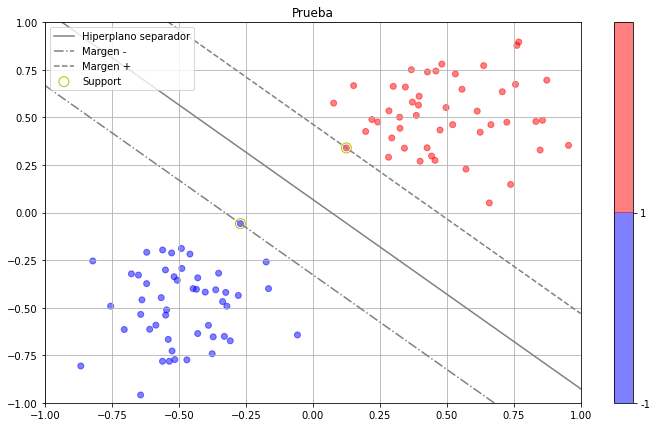

In [95]:
fig, ax = plt.subplots(1, figsize=(12, 7))
plotSvm(xTrain0, yTrain0, model00.supportVectors, model00.w, model00.b, label= None, ax=ax)
ax.set_title("Prueba")

## Caso de Prueba: Set de datos de sklearn de Cancer de mama ([info](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html))

In [96]:
DT = load_breast_cancer()
DT.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [97]:
DT['feature_names']

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [98]:
print(DT['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [99]:
print(DT['target_names'])

['malignant' 'benign']


In [100]:
print(DT['target'])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1
 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 0 1 1 0 

In [101]:
DT['data'].shape

(569, 30)

In [109]:
from sklearn.datasets import load_breast_cancer
DT = load_breast_cancer()
X = DT['data']
y = DT['target']

In [110]:
import collections
print(collections.Counter(y))

Counter({1: 357, 0: 212})


In [130]:

def preprocess(X,y):
    minmax = MinMaxScaler()
    X = minmax.fit_transform(X)
    for i in range(len(y)):
        if y[i] == 0:
            y[i] = 1
        else:
            y[i] = -1
    return X,y
X,y = preprocess(X,y)

In [131]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11)

In [132]:

model01 = SVM()
model01.fit(X_train, y_train)
model01.w, model01.b, len(model01.supportVectors)


(array([-2.77659569e+02,  1.09423989e+01, -4.57206634e+01,  2.08320889e+02,
         3.61012687e+01, -1.51557080e+02,  5.95588179e+01,  5.11428571e+01,
        -1.26763753e+01,  2.54411839e+01,  1.73087405e+01, -7.45300753e+00,
         7.45913432e+01,  1.13262180e+02, -9.63114274e-02, -2.31063607e+01,
        -4.41527081e+01,  1.05930667e+02,  1.53542991e+01, -1.33180070e+02,
         2.85493058e+01,  6.02745396e+01,  4.07505995e+01,  2.94609209e+02,
        -9.27379872e+00,  6.97560979e+01, -3.72695292e+01,  1.09873005e+01,
         1.48478043e+01,  1.04336178e+02]),
 -80.02587006041684,
 33)

In [133]:
print(f"Vector w: {model01.w}")
print(f"Valor de b: {model01.b}")
print(f"N° de vectores soporte {len(model01.supportVectors)}")

Vector w: [-2.77659569e+02  1.09423989e+01 -4.57206634e+01  2.08320889e+02
  3.61012687e+01 -1.51557080e+02  5.95588179e+01  5.11428571e+01
 -1.26763753e+01  2.54411839e+01  1.73087405e+01 -7.45300753e+00
  7.45913432e+01  1.13262180e+02 -9.63114274e-02 -2.31063607e+01
 -4.41527081e+01  1.05930667e+02  1.53542991e+01 -1.33180070e+02
  2.85493058e+01  6.02745396e+01  4.07505995e+01  2.94609209e+02
 -9.27379872e+00  6.97560979e+01 -3.72695292e+01  1.09873005e+01
  1.48478043e+01  1.04336178e+02]
Valor de b: -80.02587006041684
N° de vectores soporte 33


N° de vectores soporte = 33


Text(0, 0.5, 'mean texture')

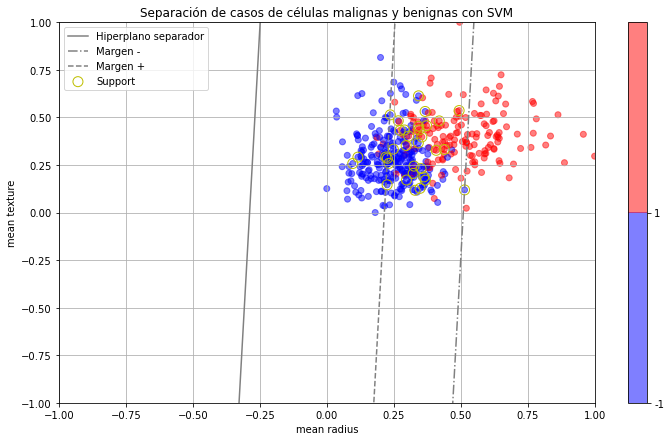

In [134]:
fig, ax = plt.subplots(1, figsize=(12, 7))
plotSvm(X_train, y_train, model01.supportVectors, model01.w, model01.b, label=None, ax=ax)
ax.set_title("Separación de casos de células malignas y benignas con SVM")
ax.set_xlabel(DT['feature_names'][0])
ax.set_ylabel(DT['feature_names'][1])

#### Al graficar solo 2 dimensiones vemos que el hiperplano de separación no se encuentra en el 0 para estas 2 variables

### Desempeño del modelo

In [116]:
def matriz_confusion(predicciones,X_test,y_test):
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for i in range(len(X_test)):
        if predicciones[i] == y_test[i]:
            if predicciones[i] == 1:
                true_positives +=1
            else:
                true_negatives +=1
        else:
            if predicciones[i] == 1:
                false_positives += 1
            else:
                false_negatives += 1
                
    print(f"Verdaderos positivos : {true_positives}")
    print(f"Verdaderos negativos : {true_negatives}")
    print(f"Falsos positivos : {false_positives}")
    print(f"Falsos negativos : {false_negatives}")
    return true_positives,true_negatives,false_positives,false_negatives
    

In [135]:
matriz_confusion(model01.predict(X_test),X_test,y_test)

Verdaderos positivos : 46
Verdaderos negativos : 90
Falsos positivos : 3
Falsos negativos : 4


(46, 90, 3, 4)

In [136]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(y_test,model01.predict(X_test))))
print('Precision Score : ' + str(precision_score(y_test,model01.predict(X_test))))
print('Recall Score : ' + str(recall_score(y_test,model01.predict(X_test))))
print('F1 Score : ' + str(f1_score(y_test,model01.predict(X_test))))

Accuracy Score : 0.951048951048951
Precision Score : 0.9387755102040817
Recall Score : 0.92
F1 Score : 0.9292929292929293


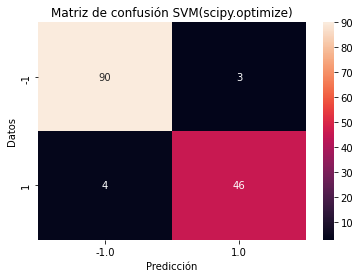

In [137]:
ax = plt.axes()


ax.set_title('Matriz de confusión SVM(scipy.optimize)')

import seaborn as sn


data = {'y_Actual':   y_test,
        'y_Predicted': model01.predict(X_test)
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Datos'], colnames=['Predicción'])

sn.heatmap(confusion_matrix, annot=True, ax=ax)
plt.show()

In [138]:
data = {'y_Actual':   y_test,
        'y_Predicted': model01.predict(X_test)
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])

In [139]:
df.head()

,y_Actual,y_Predicted
0,1,1.0
1,1,1.0
2,1,1.0
3,1,1.0
4,1,1.0


### Comparación el SVM linear de sklearn

In [119]:
from sklearn.svm import LinearSVC

In [120]:
sk_svm = LinearSVC()

In [142]:
sk_svm.fit(X_train,y_train)

LinearSVC()

In [143]:
decision_function = sk_svm.decision_function(X_train)
    
support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
support_vectors = X_train[support_vector_indices]

In [144]:
w = sk_svm.coef_ 
b = sk_svm.intercept_ 
print(f"Vector w: {w}")
print(f"Valor de b: {b}")
print(f"N° de vectores soporte {len(support_vectors)}")



Vector w: [[ 0.21456628  0.75072088  0.24977421  0.57469635 -0.16637386 -0.66314006
   1.16676393  1.61612719  0.03503649 -1.04466208  1.64838988 -0.11450261
   1.28813342  0.99957483  0.42347495 -0.73264033 -0.34631166  0.01297898
  -0.49552401 -0.41408588  1.18305745  1.50781884  1.10501712  1.13556386
   0.79341413  0.17005748  0.66502721  0.83704939  1.16813192  0.60803442]]
Valor de b: [-3.61095477]
N° de vectores soporte 135


In [145]:
matriz_confusion(sk_svm.predict(X_test),X_test,y_test)

Verdaderos positivos : 48
Verdaderos negativos : 91
Falsos positivos : 2
Falsos negativos : 2


(48, 91, 2, 2)

In [125]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(y_test,sk_svm.predict(X_test))))
print('Precision Score : ' + str(precision_score(y_test,sk_svm.predict(X_test))))
print('Recall Score : ' + str(recall_score(y_test,sk_svm.predict(X_test))))
print('F1 Score : ' + str(f1_score(y_test,sk_svm.predict(X_test))))

Accuracy Score : 0.916083916083916
Precision Score : 0.8857142857142857
Recall Score : 1.0
F1 Score : 0.9393939393939393


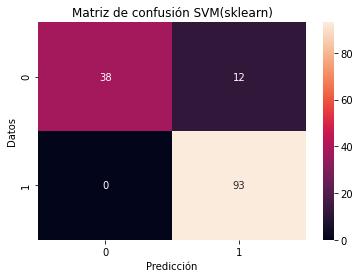

In [126]:
ax = plt.axes()


ax.set_title('Matriz de confusión SVM(sklearn)')
import seaborn as sn


data = {'y_Actual':   y_test,
        'y_Predicted': sk_svm.predict(X_test)
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Datos'], colnames=['Predicción'])

sn.heatmap(confusion_matrix, annot=True,ax=ax)
plt.show()

In [127]:
def to_df(): 
     
    
    df = np.c_[DT.data, DT.target]
    columns = np.append(DT.feature_names, ["target"])
    return pd.DataFrame(df, columns=columns)

df = to_df()

In [ ]:
df.head()
df['mean perimeter']

In [ ]:
plt.figure(figsize=(20,10))
sn.heatmap(df.corr(), annot=True)

In [ ]:

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 15))

In [ ]:
drop = ['mean perimeter','worst perimeter', 'mean area', 'worst area', 'perimeter error']
for i in drop:
    df = df.drop([i],axis=1)

In [ ]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 15))

In [ ]:
drop = ['worst radius','area error', 'mean concave points', 'worst concavity', 'mean concavity']
for i in drop:
    df = df.drop([i],axis=1)

In [ ]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 15))

In [ ]:
drop = ['worst texture','worst compactness']
for i in drop:
    df = df.drop([i],axis=1)

In [ ]:
X = df.copy()
X = X.drop(['target'],axis=1)
y = df['target']
X,y = preprocess(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11)

In [ ]:
model02 = SVM()
model02.fit(X_train, y_train)
model02.w, model02.b

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(model02.predict(X_test),y_test)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
under = RandomUnderSampler(random_state=42)
X_train, y_train = under.fit_resample(X_train, y_train)

In [ ]:
model03 = SVM()
model03.fit(X_train, y_train)
model03.w, model03.b

In [ ]:
confusion_matrix(model03.predict(X_test),y_test)

In [ ]:
sn.pairplot(df, hue='target', vars=['mean radius', 'mean texture', 'mean area', 'mean perimeter', 'mean smoothness'])

### Conclusión

#### A través del modelo utilizando scipy optimize para maximizar el margen de clasificación entre clases, se logró un modelo efectivo para separar clases linealmente separables que incluso tiene buenos resultados en casos más complejos como las 30 características del set de datos de Cancer de mamá de Wisconsin. 
#### Frente al SVM linear por defecto de sklearn, empeora un poco las métricas pero la característica con más desventaja es el tiempo de cómputo que requiere la implementación propuesta que supera ampliamente al modelo de sklearn.